In [1]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00


In [36]:
# @title
import pandas as pd
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Path of the file
file_path = '/content/drive/My Drive/ViolenceSegmentation/monthlyViolenceColombia.xlsx'
path_images = '/content/drive/My Drive/ViolenceSegmentation/images'

df = pd.read_excel(file_path, sheet_name="violence_indicators")
dfDataOrig = df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# @title
df.head()

,period,Cases of collective violence,Cases of indiscriminate violence,Cases of selective violence,Victims of collective violence,Victims of indiscriminate violence,Victims of selective violence
0,1958/01,40,3,37,104,8,96
1,1958/02,22,2,20,84,11,73
2,1958/03,37,8,29,98,53,45
3,1958/04,23,6,17,53,24,29
4,1958/05,7,4,3,27,9,18


In [25]:
# @title
import math
import numpy as np
import ruptures as rpt
from ruptures.base import BaseCost

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
import numpy as np
from typing import List

from __future__ import annotations
from typing import Dict, Any, Optional, Tuple
from pathlib import Path
from typing import List, Tuple


class CostNegBinomial(BaseCost):
    """
    Negative Binomial (NB2) segment cost with a fixed global dispersion.
    Cost for segment [start, end):
        C = (n*r + S) * log(1 + S/(n*r)) + S * log((n*r)/S)
    where n = end - start, S = sum(y[start:end]).
    Convention: if S == 0, C = 0 (correct limit).
    """
    model = "neg_binom"

    def __init__(self, r=5.0, min_size=2, jump=1):
        if r <= 0:
            raise ValueError("Dispersion parameter r must be positive.")
        self.r = float(r)
        self.min_size = int(min_size)
        self.jump = int(jump)
        self._cum_sum = None
        self._n_samples = None
        self.signal = Nonel

    def fit(self, signal):
        """
        signal: array-like of shape (T,) or (T,1); non-negative counts.
        """
        y = np.asarray(signal)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        if y.shape[1] != 1:
            raise ValueError("CostNegBinomial supports univariate series only (counts).")
        if np.any(y < 0):
            raise ValueError("Found negative values; expected non-negative counts.")

        self.signal = y
        self._n_samples = y.shape[0]
        y1 = y[:, 0].astype(float)
        self._cum_sum = np.concatenate(([0.0], np.cumsum(y1)))
        return self

    def error(self, start, end):
        """
        Segment cost for [start, end).
        """
        n = end - start
        if n < self.min_size:
            return np.inf

        S = self._cum_sum[end] - self._cum_sum[start]
        if S <= 0.0:
            # All-zero segment (or numerically zero): limit cost is 0
            return 0.0

        r = self.r
        # Stable form: log(1 + S/(n*r)) and log((n*r)/S)
        return (n * r + S) * math.log1p(S / (n * r)) + S * (math.log(n * r) - math.log(S))

    def sum_of_costs(self, bkps):
        start = 0
        total = 0.0
        for end in bkps:
            total += self.error(start, end)
            start = end
        return total

def estimate_r_nb2_global(y):
    """
    Estimate the global dispersion parameter 'r' using the NB2 method of moments.
    If there is no overdispersion, return a large r (≈ Poisson).
    """
    y = np.asarray(y).astype(float).reshape(-1)
    mu = y.mean()
    var = y.var(ddof=1) if y.size > 1 else 0.0
    # If there is overdispersion
    if var > mu and mu > 0:
        r_hat = (mu * mu) / (var - mu)
        # Avoid extreme values
        return float(max(r_hat, 1e-6))
    else:
        # No apparent overdispersion
        return 1e6  # approximates Poisson


def compute_time_ticks(start_dt: pd.Timestamp,
                       end_dt: pd.Timestamp,
                       year_interval: int = 5,
                       include_edges: bool = True,
                       drop_first_after_start: bool = True,
                       drop_last_before_end: bool = True) -> list[pd.Timestamp]:
    """Compute YYYY/01 ticks every `year_interval` years strictly within [start_dt, end_dt]."""
    if not isinstance(start_dt, pd.Timestamp):
        start_dt = pd.to_datetime(start_dt)
    if not isinstance(end_dt, pd.Timestamp):
        end_dt = pd.to_datetime(end_dt)
    if start_dt > end_dt:
        start_dt, end_dt = end_dt, start_dt

    base_year = (start_dt.year // year_interval) * year_interval
    first_jan = pd.Timestamp(year=base_year, month=1, day=1)
    if first_jan < start_dt.normalize():
        first_jan = pd.Timestamp(year=base_year + year_interval, month=1, day=1)

    anchors = pd.date_range(start=first_jan, end=end_dt, freq=f'{year_interval}YS')
    ticks = list(anchors)

    if include_edges:
        ticks.append(start_dt)
        ticks.append(end_dt)

    ticks = sorted({t for t in ticks if start_dt <= t <= end_dt})

    if drop_first_after_start and len(ticks) > 2:
        for i, t in enumerate(ticks):
            if t > start_dt:
                ticks.pop(i)
                break

    if drop_last_before_end and len(ticks) > 2:
        for i in range(len(ticks) - 1, -1, -1):
            if ticks[i] < end_dt:
                ticks.pop(i)
                break

    return ticks

def apply_time_ticks(ax,
                     ticks: list[pd.Timestamp],
                     fmt: str = '%Y/%m',
                     rotation: int = 45,
                     ha: str = 'right',
                     font_size: int = 8):
    """Apply precomputed datetime ticks to a Matplotlib Axes with smaller fonts."""
    ax.xaxis.set_major_locator(FixedLocator([mdates.date2num(t) for t in ticks]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.setp(ax.get_xticklabels(), rotation=rotation, ha=ha, fontsize=font_size)


[Victims of collective violence] T=768  r_hat=0.499
  baseline: k=6, bkps=[100, 275, 325, 460, 580, 685, 768]
  chosen:   k=6, pen=4.600, bkps=[100, 275, 325, 460, 580, 685, 768]


/tmp/ipython-input-2268572323.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates


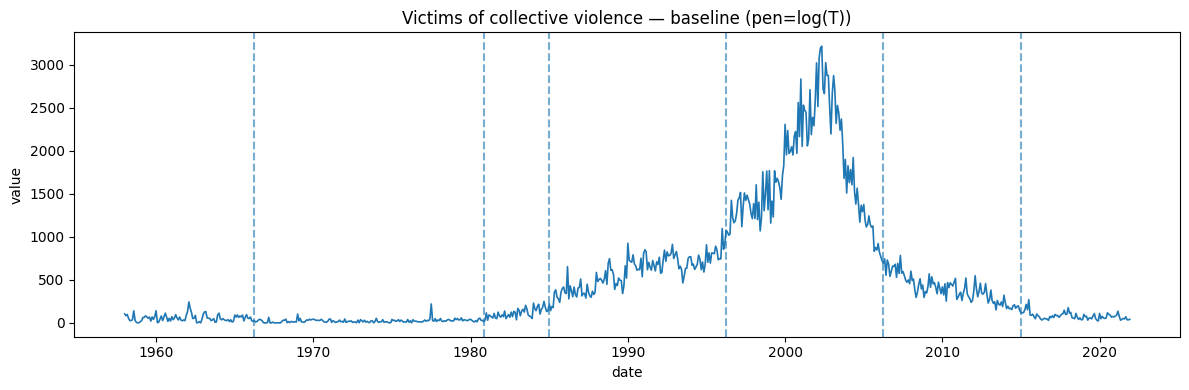

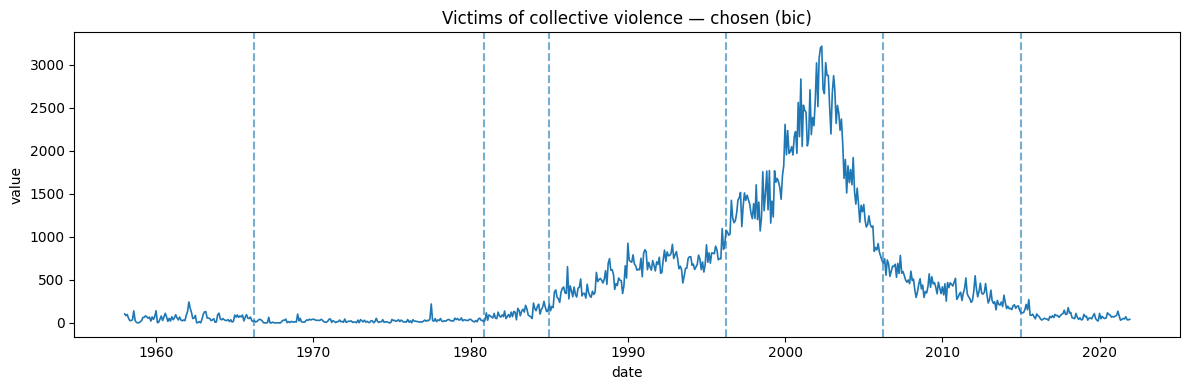


[Cases of collective violence] T=768  r_hat=0.486
  baseline: k=7, bkps=[105, 120, 275, 335, 455, 580, 685, 768]
  chosen:   k=5, pen=7.581, bkps=[275, 335, 455, 580, 685, 768]


/tmp/ipython-input-2268572323.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates


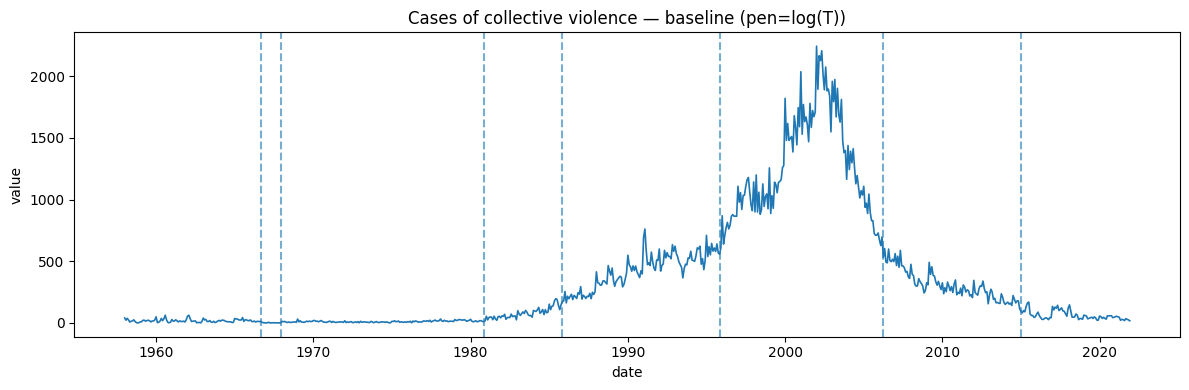

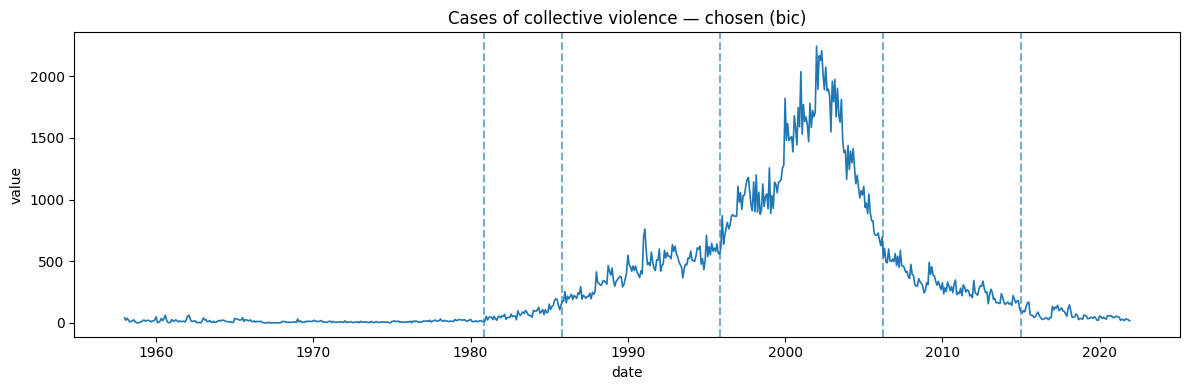


[Victims of indiscriminate violence] T=768  r_hat=0.683
  baseline: k=4, bkps=[315, 515, 550, 690, 768]
  chosen:   k=4, pen=6.729, bkps=[315, 515, 550, 690, 768]


/tmp/ipython-input-2268572323.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates


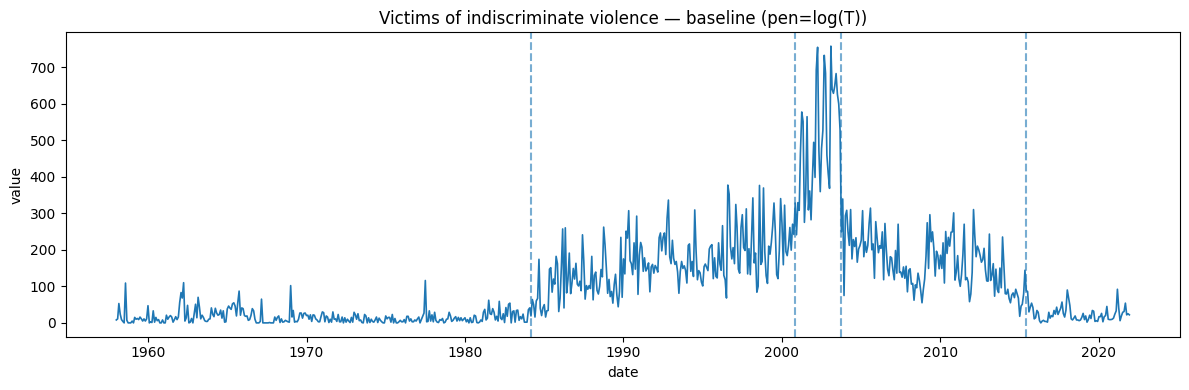

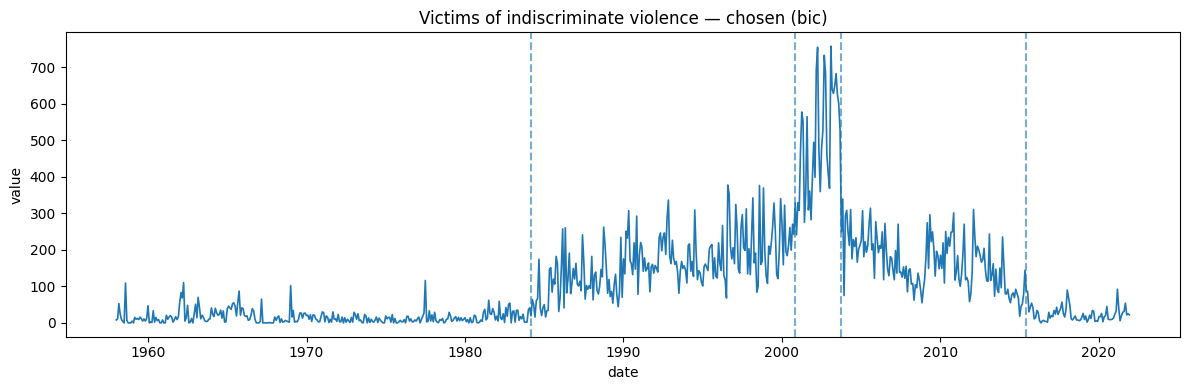


[Cases of indiscriminate violence] T=768  r_hat=0.712
  baseline: k=7, bkps=[105, 120, 275, 330, 515, 665, 725, 768]
  chosen:   k=4, pen=7.155, bkps=[330, 515, 665, 725, 768]


/tmp/ipython-input-2268572323.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates


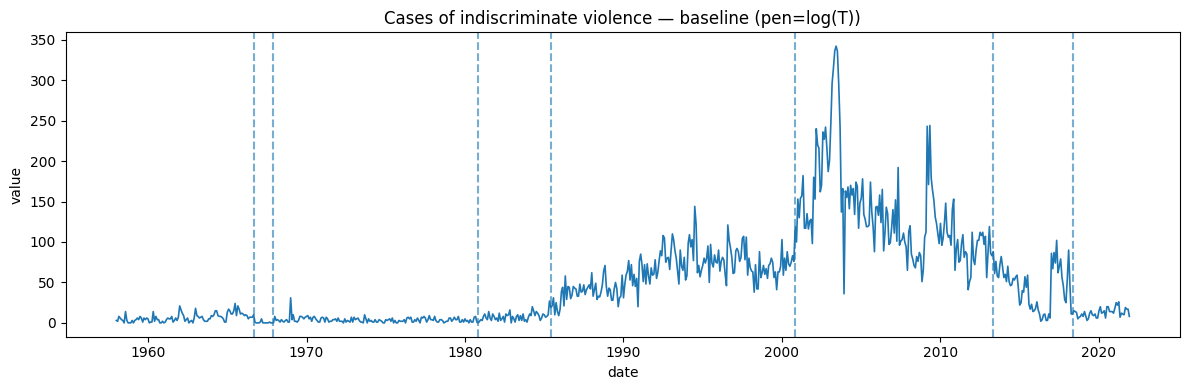

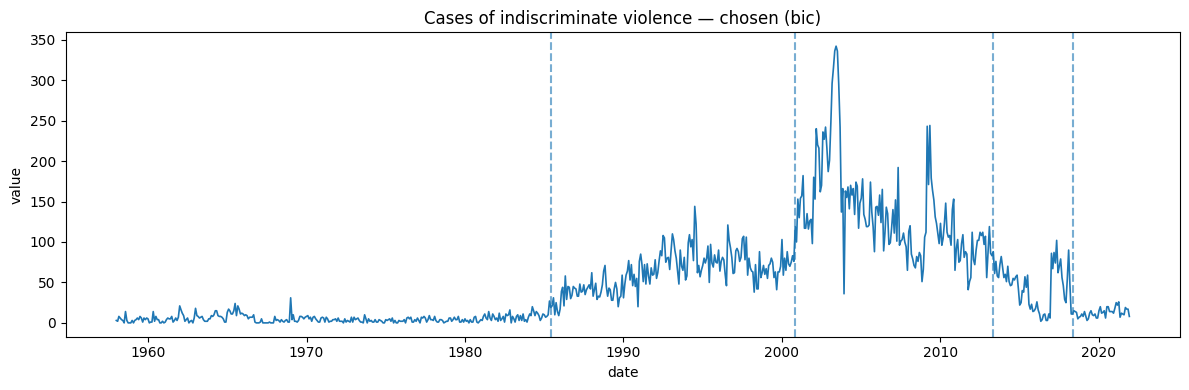


[Victims of selective violence] T=768  r_hat=0.431
  baseline: k=7, bkps=[95, 230, 275, 335, 460, 575, 665, 768]
  chosen:   k=6, pen=6.729, bkps=[75, 275, 335, 460, 575, 665, 768]


/tmp/ipython-input-2268572323.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates


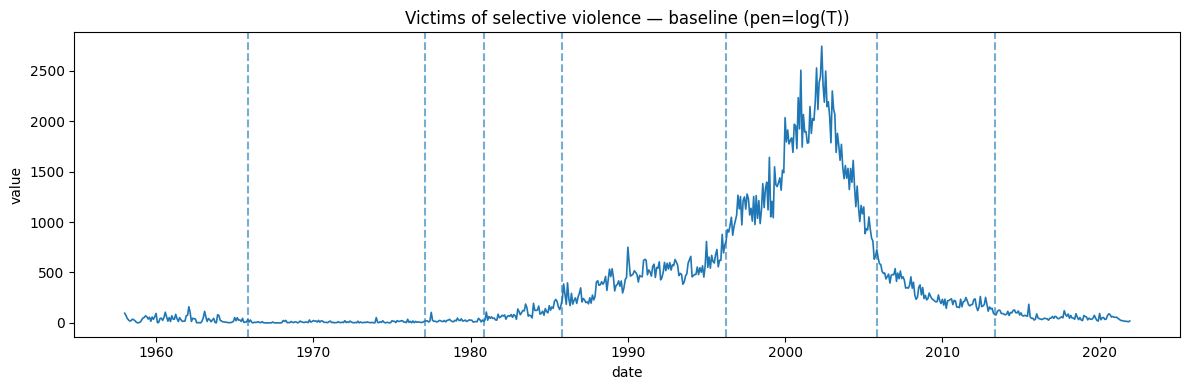

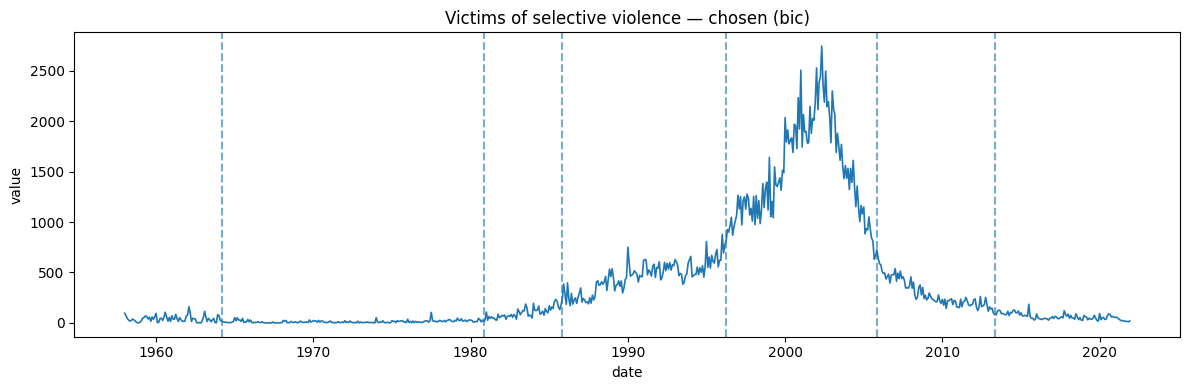


[Cases of selective violence] T=768  r_hat=0.432
  baseline: k=7, bkps=[95, 225, 275, 335, 455, 580, 685, 768]
  chosen:   k=7, pen=6.729, bkps=[95, 225, 275, 335, 455, 580, 685, 768]


/tmp/ipython-input-2268572323.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates


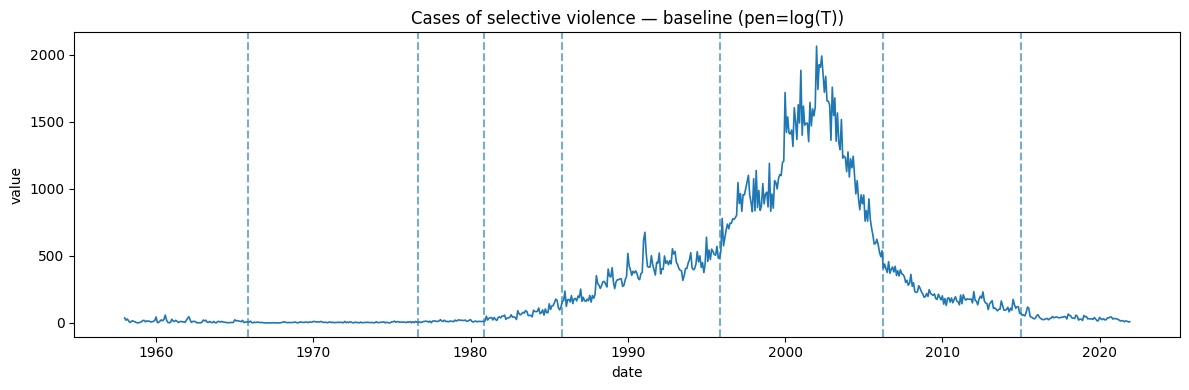

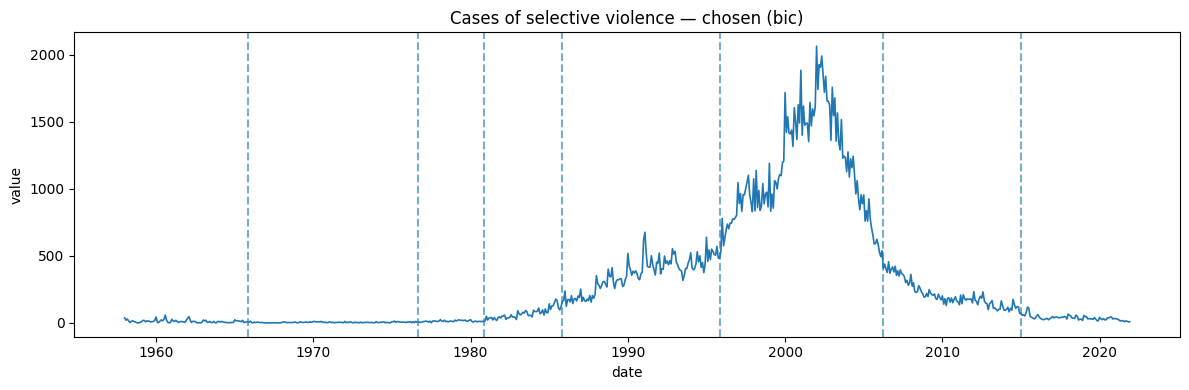

In [26]:
# @title
import math
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

# ------------------------------------------------------------
#   - estimate_r_nb2_global(y)
#   - CostNegBinomial(r=..., min_size=...).fit(y2d)
# ------------------------------------------------------------

def pelt_nb_sweep(y, *, min_size=5, n_pens=40, pen_min_mult=0.5, pen_max_mult=3.0, strategy="bic"):
    """
    PELT with NB custom cost + penalty sweep + simple selection.
    Returns dict: chosen + results + baseline.
    """
    y = np.asarray(y, dtype=float)
    T = len(y)

    # NB cost
    r_hat = estimate_r_nb2_global(y)
    y2d = y.reshape(-1, 1)
    cost = CostNegBinomial(r=r_hat, min_size=min_size).fit(y2d)

    algo = rpt.Pelt(model="custom", custom_cost=cost).fit(y2d)

    # baseline: pen = log(T)
    pen0 = math.log(T)
    bkps0 = algo.predict(pen=pen0)

    # sweep pens in [a log(T), b log(T)]
    pen_min = pen_min_mult * pen0
    pen_max = pen_max_mult * pen0
    pens = np.linspace(pen_min, pen_max, n_pens)

    results = []
    seen = set()
    for p in pens:
        bkps = tuple(algo.predict(pen=float(p)))
        if bkps in seen:
            continue
        seen.add(bkps)
        k = len(bkps) - 1
        unpen = float(cost.sum_of_costs(list(bkps)))
        pcost = unpen + float(p) * k
        results.append({"pen": float(p), "bkps": list(bkps), "k": k, "unpen": unpen, "pcost": float(pcost)})

    # choose
    if strategy == "pcost":
        chosen = min(results, key=lambda d: d["pcost"])
    elif strategy == "bic":
        target = math.log(T)
        chosen = min(results, key=lambda d: abs(d["pen"] - target))
    elif strategy == "stable":
        # pick the segmentation that appears across the widest penalty range
        # (simple plateau version)
        res_sorted = sorted(results, key=lambda d: d["pen"])
        groups = []
        current = [res_sorted[0]]
        for d in res_sorted[1:]:
            if d["bkps"] == current[-1]["bkps"]:
                current.append(d)
            else:
                groups.append(current)
                current = [d]
        groups.append(current)
        best = max(groups, key=lambda g: g[-1]["pen"] - g[0]["pen"])
        chosen = best[len(best)//2]
    else:
        raise ValueError("strategy must be one of: 'pcost', 'bic', 'stable'")

    return {
        "T": T,
        "r_hat": float(r_hat),
        "baseline": {"pen": float(pen0), "bkps": bkps0, "k": len(bkps0) - 1},
        "results": sorted(results, key=lambda d: d["pen"]),
        "chosen": chosen
    }


def plot_bkps(y, bkps, title="", x=None):
    """Minimal plot. x optional (e.g., datetime array)."""
    y = np.asarray(y)
    plt.figure(figsize=(12, 4))
    if x is None:
        plt.plot(y, lw=1.2)
        for b in bkps[:-1]:
            plt.axvline(b - 1, ls="--", alpha=0.6)
        plt.xlabel("t")
    else:
        plt.plot(x, y, lw=1.2)
        for b in bkps[:-1]:
            plt.axvline(x[b - 1], ls="--", alpha=0.6)
        plt.xlabel("date")
    plt.title(title)
    plt.ylabel("value")
    plt.tight_layout()
    plt.show()



# ------------------------------------------------------------
# Run on each indicator
# ------------------------------------------------------------
idIndicatorViolenceList = [
    'Victims of collective violence','Cases of collective violence',
    'Victims of indiscriminate violence','Cases of indiscriminate violence',
    'Victims of selective violence','Cases of selective violence'
]

all_runs = {}
baselineResults = {}
for ind in idIndicatorViolenceList:
    y = np.asarray(dfDataOrig[ind].values, dtype=float)

    out = pelt_nb_sweep(
        y,
        min_size=5,
        n_pens=40,
        pen_min_mult=0.5,
        pen_max_mult=3.0,
        strategy="bic"   # or "pcost" / "stable"
    )

    all_runs[ind] = out

    print(f"\n[{ind}] T={out['T']}  r_hat={out['r_hat']:.3f}")
    print(f"  baseline: k={out['baseline']['k']}, bkps={out['baseline']['bkps']}")
    print(f"  chosen:   k={out['chosen']['k']}, pen={out['chosen']['pen']:.3f}, bkps={out['chosen']['bkps']}")
    baselineResults[ind] = [out['chosen']['bkps'],y]

    # optional quick plots
    x_dates = pd.to_datetime(df['period'].to_numpy())  # if you have dates
    plot_bkps(y, out["baseline"]["bkps"], title=f"{ind} — baseline (pen=log(T))", x=x_dates)
    plot_bkps(y, out["chosen"]["bkps"], title=f"{ind} — chosen ({'bic'})", x=x_dates)


In [31]:
# @title
import pandas as pd
import numpy as np

# --- Census years and annual estimates (anchor points) ---
data = {
    "year": [1951, 1964, 1973, 1985, 1993, 2005, 2018, 2019, 2020, 2021],
    "population": [11548172, 17484510, 20666920, 27853432,
                   33109839, 41468384, 48258494, 49395678,
                   50372424, 51049498]
}
df_year = pd.DataFrame(data)
df_year["date"] = pd.to_datetime(df_year["year"].astype(str) + "-01-01")
df_year = df_year.set_index("date")[["population"]].sort_index()

# Monthly interpolation between the first and last available data
full_monthly_idx = pd.date_range(df_year.index.min(), df_year.index.max(), freq="MS")
df_full = df_year.reindex(full_monthly_idx).interpolate(method="time")

# Linearly extend from 2021-02 to 2021-12 using the most recent annual increment
p_2020 = df_year.loc[pd.Timestamp("2020-01-01"), "population"]
p_2021 = df_year.loc[pd.Timestamp("2021-01-01"), "population"]
annual_inc_last = p_2021 - p_2020
monthly_inc_last = annual_inc_last / 12.0

ext_idx = pd.date_range("2021-02-01", "2021-12-01", freq="MS")
start_val = df_full.loc[pd.Timestamp("2021-01-01"), "population"]
ext_vals = start_val + monthly_inc_last * np.arange(1, len(ext_idx) + 1)
df_ext = pd.DataFrame({"population": ext_vals}, index=ext_idx)

df_monthly_all = pd.concat([df_full, df_ext]).sort_index()

df_monthly = df_monthly_all.loc["1958-01-01":"2021-12-01"].reset_index()
df_monthly = df_monthly.rename(columns={"index": "date"})


# Export to Excel
file_path = "colombia_population_monthly_1958_2021.xlsx"
df_monthly.to_excel(file_path, index=False)

In [32]:
# @title
from __future__ import annotations

import numpy as np
import pandas as pd
import ruptures as rpt
from ruptures.base import BaseCost
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Union, NamedTuple
from scipy.special import gammaln

# Date helpers for plotting
def _dates_from_index_or_build(T: int,
                               dates: Optional[pd.DatetimeIndex] = None,
                               start: Optional[str | pd.Timestamp] = None,
                               freq: str = "MS") -> pd.DatetimeIndex:
    """Return a DatetimeIndex of length T (use provided `dates` or build from `start`/`freq`)."""
    if dates is not None:
        if not isinstance(dates, pd.DatetimeIndex):
            dates = pd.to_datetime(dates)
        if len(dates) != T:
            raise ValueError("Length of 'dates' must match len(y).")
        return dates
    if start is None:
        start = "2000-01-01"
    return pd.date_range(start=pd.to_datetime(start), periods=T, freq=freq)


# Method-of-moments dispersion for NB2
def estimate_alpha_nb2(y: np.ndarray) -> float:
    """Method-of-moments dispersion for NB2; falls back to ~Poisson when tiny."""
    y = np.asarray(y, dtype=float).ravel()
    m = y.mean()
    v = y.var(ddof=1) if y.size > 1 else y.var()
    alpha = (v - m) / (m**2 + 1e-12)
    return float(max(alpha, 1e-12))

def design_linear_time(T: int) -> np.ndarray:
    """Design [1, t] with t scaled to [-0.5, 0.5]."""
    t = np.linspace(-0.5, 0.5, T)
    return np.column_stack([np.ones(T), t])

def nb2_loglike_vector(y: np.ndarray, mu: np.ndarray, alpha: float,
                       precomp_logfact: Optional[np.ndarray] = None) -> float:
    """NB2 log-likelihood (sum over observations); Poisson limit when alpha≈0."""
    y = np.asarray(y, dtype=float); mu = np.asarray(mu, dtype=float)
    if alpha < 1e-12:  # Poisson
        logfact = gammaln(y + 1.0) if precomp_logfact is None else precomp_logfact
        return float(np.sum(y * np.log(mu + 1e-300) - mu - logfact))
    r = 1.0 / alpha
    out = gammaln(y + r) - gammaln(r) - gammaln(y + 1.0)
    out += r * (np.log(r) - np.log(r + mu)) + y * (np.log(mu + 1e-300) - np.log(r + mu))
    return float(np.sum(out))

def nb_glm_irls_segment(y: np.ndarray, X: np.ndarray, alpha: float,
                        max_iter: int = 60, tol: float = 1e-8, ridge: float = 1e-8) -> Tuple[np.ndarray, float]:
    """IRLS for NB2 with log link on one segment; returns (beta, loglik)."""
    eps = 1e-6
    y = np.asarray(y, dtype=float).ravel(); X = np.asarray(X, dtype=float)
    y_pos = np.clip(y, eps, None)
    # Poisson GLM warm start on log(y)
    beta = np.linalg.lstsq(X.T @ X + ridge * np.eye(X.shape[1]), X.T @ np.log(y_pos), rcond=None)[0]
    logfact = gammaln(y + 1.0)
    for _ in range(max_iter):
        eta = X @ beta
        mu  = np.exp(np.clip(eta, -40, 40))
        W   = mu / (1.0 + alpha * mu)           # diagonal weights
        z   = eta + (y - mu) / np.clip(mu, eps, None)
        XtW = X.T * W
        H   = XtW @ X + ridge * np.eye(X.shape[1])
        g   = XtW @ z
        beta_new = np.linalg.solve(H, g)
        if np.linalg.norm(beta_new - beta, ord=np.inf) < tol:
            beta = beta_new; break
        beta = beta_new
    mu_hat = np.exp(np.clip(X @ beta, -40, 40))
    ll = nb2_loglike_vector(y, mu_hat, alpha, precomp_logfact=logfact)
    return beta, ll

# Population covariate helpers
def _prepare_pop_cov(pop: Union[np.ndarray, pd.Series, list],
                     log: bool = True,
                     standardize: bool = True) -> np.ndarray:
    """Build 1D population covariate (optional log + standardize)."""
    pop = np.asarray(pd.Series(pop).astype(float)).ravel()
    if log:
        pop = np.log(np.clip(pop, 1e-12, None))
    if standardize:
        m = pop.mean()
        s = pop.std(ddof=1)
        pop = (pop - m) / (s if s > 0 else 1.0)
    return pop

def design_linear_time_pop(T: int, pop_cov: np.ndarray) -> np.ndarray:
    """Design [1, t, pop_cov] where t is scaled to [-0.5, 0.5]."""
    if pop_cov.shape[0] != T:
        raise ValueError("Population covariate length must match len(y).")
    t = np.linspace(-0.5, 0.5, T)
    return np.column_stack([np.ones(T), t, pop_cov])

# Custom cost functions
@dataclass
class CostNBConst(BaseCost):
    alpha: Optional[float] = None
    min_size: int = 20
    def model(self) -> str: return "nb_const"
    def fit(self, signal: np.ndarray) -> "CostNBConst":
        y = np.asarray(signal).ravel()
        self.signal = y[:, None]  # required by ruptures (2D)
        self._y = y; self._T = len(y)
        self._alpha = estimate_alpha_nb2(y) if (self.alpha is None) else float(self.alpha)
        self._prefix_y = np.concatenate([[0.0], np.cumsum(y)])
        self._prefix_lgy1 = np.concatenate([[0.0], np.cumsum(gammaln(y + 1.0))])
        self._prefix_lgy_r = None
        if self._alpha >= 1e-12:
            r = 1.0 / self._alpha
            self._prefix_lgy_r = np.concatenate([[0.0], np.cumsum(gammaln(y + r))])
        return self
    def error(self, start: int, end: int) -> float:
        n = end - start
        if n < self.min_size: return np.inf
        sum_y = self._prefix_y[end] - self._prefix_y[start]
        sum_lgy1 = self._prefix_lgy1[end] - self._prefix_lgy1[start]
        if self._alpha < 1e-12:  # Poisson
            mu_hat = sum_y / n
            ll = sum_y * np.log(mu_hat + 1e-300) - n * mu_hat - sum_lgy1
            return -2.0 * ll
        r = 1.0 / self._alpha
        sum_lgy_r = self._prefix_lgy_r[end] - self._prefix_lgy_r[start]
        mu_hat = sum_y / n
        const_term = (sum_lgy_r - n * gammaln(r) - sum_lgy1)
        ll = const_term + n * (r * np.log(r)) - (sum_y + n * r) * np.log(r + mu_hat) + sum_y * np.log(mu_hat + 1e-300)
        return -2.0 * ll
    def cost(self, start: int, end: int) -> float: return self.error(start, end)

@dataclass
class CostNBGLMLinear(BaseCost):
    alpha: Optional[float] = None
    min_size: int = 20
    max_iter: int = 60
    tol: float = 1e-8
    ridge: float = 1e-8
    def model(self) -> str: return "nb_glm_linear"
    def fit(self, signal: np.ndarray) -> "CostNBGLMLinear":
        y = np.asarray(signal).ravel()
        self.signal = y[:, None]
        self._y = y; self._T = len(y)
        self._alpha = estimate_alpha_nb2(y) if (self.alpha is None) else float(self.alpha)
        self._X = design_linear_time(self._T)
        self._cache: Dict[Tuple[int, int], float] = {}
        return self
    def error(self, start: int, end: int) -> float:
        if (end - start) < self.min_size: return np.inf
        key = (start, end)
        if key in self._cache: return self._cache[key]
        y_seg = self._y[start:end]
        X_seg = self._X[start:end, :]
        _, ll = nb_glm_irls_segment(y_seg, X_seg, self._alpha,
                                    max_iter=self.max_iter, tol=self.tol, ridge=self.ridge)
        c = -2.0 * ll
        self._cache[key] = c
        return c
    def cost(self, start: int, end: int) -> float: return self.error(start, end)

def design_pop_only(T: int, pop_cov: np.ndarray) -> np.ndarray:
    """Design [1, pop_cov]."""
    if pop_cov.shape[0] != T:
        raise ValueError("Population covariate length must match len(y).")
    return np.column_stack([np.ones(T), pop_cov])

@dataclass
class CostNBGLMPopOnly(BaseCost):
    pop_cov: Optional[np.ndarray] = None
    alpha: Optional[float] = None
    min_size: int = 20
    max_iter: int = 60
    tol: float = 1e-8
    ridge: float = 1e-8
    def model(self) -> str: return "nb_glm_pop"
    def fit(self, signal: np.ndarray) -> "CostNBGLMPopOnly":
        y = np.asarray(signal).ravel()
        self.signal = y[:, None]
        self._y = y; self._T = len(y)
        if self.pop_cov is None or len(self.pop_cov) != self._T:
            raise ValueError("pop_cov must be provided and aligned with y.")
        self._alpha = estimate_alpha_nb2(y) if (self.alpha is None) else float(self.alpha)
        self._X = design_pop_only(self._T, self.pop_cov)
        self._cache: Dict[Tuple[int,int], float] = {}
        return self
    def error(self, start: int, end: int) -> float:
        if (end - start) < self.min_size: return np.inf
        key = (start, end)
        if key in self._cache: return self._cache[key]
        y_seg = self._y[start:end]
        X_seg = self._X[start:end, :]
        _, ll = nb_glm_irls_segment(y_seg, X_seg, self._alpha,
                                    max_iter=self.max_iter, tol=self.tol, ridge=self.ridge)
        c = -2.0 * ll
        self._cache[key] = c
        return c
    def cost(self, start: int, end: int) -> float: return self.error(start, end)

# Breakpoints & runner
def ensure_bkps_with_edges(bkps: list[int], T: int) -> list[int]:
    """Return sorted unique breakpoint indices including 0 and T."""
    s = set(bkps); s.add(0); s.add(T)
    full = sorted(s)
    out = [full[0]]
    for b in full[1:]:
        if b != out[-1]:
            out.append(b)
    return out

def run_pelt_nb(y: np.ndarray,
                model: str = "nb_glm_linear",
                min_size: int = 20,
                penalty: Union[str, float] = "bic",
                *,
                df_monthly: Optional[pd.DataFrame] = None,
                pop_col: str = "population",
                pop_log: bool = True,
                pop_standardize: bool = True) -> Tuple[List[int], Dict]:
    """
    Run PELT with NB-based costs.
    Models:
      - 'nb_const'             : constant mean per segment
      - 'nb_glm_linear'        : intercept + linear time
      - 'nb_glm_linear_pop'    : intercept + linear time + population covariate

    For 'nb_glm_linear_pop', pass df_monthly with column `pop_col` aligned with y.
    """
    y = np.asarray(y, dtype=float).ravel()
    T = len(y)

    if model == "nb_const":
        cost = CostNBConst(min_size=min_size).fit(y); dof = 1
    elif model == "nb_glm_linear":
        cost = CostNBGLMLinear(min_size=min_size).fit(y); dof = 2
    elif model == "nb_glm_linear_pop":
        if df_monthly is None or pop_col not in df_monthly.columns:
            raise ValueError("df_monthly with population is required for 'nb_glm_pop'.")
        pop_raw = df_monthly[pop_col].to_numpy()
        if len(pop_raw) != T:
            raise ValueError("df_monthly[population] length must equal len(y).")
        pop_cov = _prepare_pop_cov(pop_raw, log=pop_log, standardize=pop_standardize)
        cost = CostNBGLMPopOnly(pop_cov=pop_cov, min_size=min_size).fit(y)
        dof = 2  # intercept + population
    else:
        raise ValueError("model must be 'nb_const', 'nb_glm_linear', or 'nb_glm_linear_pop'.")

    # Penalty (BIC default)
    pen = np.log(T) * dof if (isinstance(penalty, str) and penalty.lower() == "bic") \
          else float(penalty)

    # PELT
    algo = rpt.Pelt(model="custom", custom_cost=cost, min_size=min_size).fit(y)
    bkps = algo.predict(pen=pen)                         # usually ends with T
    bkps_with_edges = ensure_bkps_with_edges(bkps, T)

    info = dict(
        alpha=getattr(cost, "_alpha", None),
        penalty=pen,
        dof=dof,
        model=model,
        bkps=bkps,
        bkps_with_edges=bkps_with_edges
    )
    return bkps_with_edges, info

# Refitting
def fitted_mu_per_segment(y: np.ndarray, bkps: List[int], model: str,
                          alpha: Optional[float] = None,
                          *,
                          df_monthly: Optional[pd.DataFrame] = None,
                          pop_col: str = "population",
                          pop_log: bool = True,
                          pop_standardize: bool = True) -> np.ndarray:
    """Compute fitted mean per index using the chosen model on each segment."""
    y = np.asarray(y, dtype=float).ravel()
    T = len(y)
    mu_hat = np.empty(T, dtype=float)

    if model == "nb_const":
        start = 0
        for end in bkps:
            seg = slice(start, end)
            mu_hat[seg] = y[seg].mean()
            start = end

    elif model == "nb_glm_linear":
        X = design_linear_time(T)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        start = 0
        for end in bkps:
            seg = slice(start, end)
            beta, _ = nb_glm_irls_segment(y[seg], X[seg, :], a)
            mu_hat[seg] = np.exp(np.clip(X[seg, :] @ beta, -40, 40))
            start = end

    elif model == "nb_glm_linear_pop":
        if df_monthly is None or pop_col not in df_monthly.columns:
            raise ValueError("df_monthly with population is required for 'nb_glm_linear_pop'.")
        pop_cov = _prepare_pop_cov(df_monthly[pop_col].to_numpy(),
                                   log=pop_log, standardize=pop_standardize)
        X = design_linear_time_pop(T, pop_cov)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        start = 0
        for end in bkps:
            seg = slice(start, end)
            beta, _ = nb_glm_irls_segment(y[seg], X[seg, :], a)
            mu_hat[seg] = np.exp(np.clip(X[seg, :] @ beta, -40, 40))
            z = X[seg, :] @ beta
            start = end
    else:
        raise ValueError("model must be 'nb_const', 'nb_glm_linear', or 'nb_glm_linear_pop'.")

    return mu_hat


def plot_series_with_bkps_and_fit(y: np.ndarray,
                                  bkps_with_edges: List[int],
                                  model: str,
                                  alpha: Optional[float] = None,
                                  title: Optional[str] = None,
                                  figsize=(12, 4), dpi=120,
                                  *,
                                  dates: Optional[pd.DatetimeIndex] = None,
                                  start: Optional[str | pd.Timestamp] = None,
                                  freq: str = "MS",
                                  ticks: Optional[list[pd.Timestamp]] = None,
                                  tick_fmt: str = "%Y",
                                  tick_rotation: int = 45,
                                  tick_font_size: int = 12,
                                  label_y_axis: str = "",
                                  df_monthly: Optional[pd.DataFrame] = None,):
    """Date x-axis, vertical lines at breakpoints, and 5-year ticks."""
    y = np.asarray(y).ravel()
    T = len(y)
    xdates = _dates_from_index_or_build(T, dates=dates, start=start, freq=freq)

    mu_hat = fitted_mu_per_segment(y, bkps_with_edges[1:], model, alpha=alpha,df_monthly=df_monthly)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(xdates, y, lw=1, label="x", color="black")
    ax.plot(xdates, np.clip(mu_hat,0,np.max(y)), lw=2, label="fitted μ", color="orange")

    # vertical lines at all breakpoints (including edges)
    for b in bkps_with_edges:
        ax.axvline(x=xdates[b-1 if b > 0 else 0], ls="--", lw=1, color="black", alpha=0.7)

    ax.set_xlabel("Year", fontsize=tick_font_size)
    ax.set_ylabel(label_y_axis, fontsize=tick_font_size)
    ax.tick_params(axis='y', labelsize=tick_font_size)
    ax.legend()

    if ticks is None:
        ticks = compute_time_ticks(xdates[0], xdates[-1], year_interval=5, include_edges=True)
    apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)

    fig.tight_layout()
    plt.show()


# Per-segment summary
class SegmentFit(NamedTuple):
    start: int
    end: int
    beta: np.ndarray  # parameter vector for the given design

def segment_params_summary(y: np.ndarray,
                           bkps_with_edges: list[int],
                           model: str,
                           alpha: float | None = None,
                           *,
                           df_monthly: Optional[pd.DataFrame] = None,
                           pop_col: str = "population",
                           pop_log: bool = True,
                           pop_standardize: bool = True) -> tuple[list[dict], pd.DataFrame]:
    """
    Return (list_of_dicts, DataFrame) with per-segment parameters.
    For 'nb_glm_linear_pop', includes the population regressor.
    """
    y = np.asarray(y, dtype=float).ravel()
    T = y.size
    rows: list[dict] = []

    if model == "nb_const":
        for i, (s, e) in enumerate(zip(bkps_with_edges[:-1], bkps_with_edges[1:]), start=1):
            mu_hat = float(np.clip(y[s:e].mean(), 1e-12, None))
            rows.append(dict(
                seg=i, start=s, end=e, length=e - s,
                model="nb_const", mu=mu_hat,
                beta0=np.log(mu_hat), beta1=0.0
            ))

    elif model == "nb_glm_linear":
        X = design_linear_time(T)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        for i, (s, e) in enumerate(zip(bkps_with_edges[:-1], bkps_with_edges[1:]), start=1):
            beta, _ = nb_glm_irls_segment(y[s:e], X[s:e, :], a)
            mu_hat_seg = float(np.exp(np.clip(X[s:e, :] @ beta, -40, 40)).mean())
            rows.append(dict(
                seg=i, start=s, end=e, length=e - s,
                model="nb_glm_linear", mu=mu_hat_seg,
                beta0=float(beta[0]), beta1=float(beta[1])
            ))

    elif model == "nb_glm_linear_pop":
        if df_monthly is None or pop_col not in df_monthly.columns:
            raise ValueError("df_monthly with population is required for 'nb_glm_linear_pop'.")
        pop_cov = _prepare_pop_cov(df_monthly[pop_col].to_numpy(),
                                   log=pop_log, standardize=pop_standardize)
        X = design_linear_time_pop(T, pop_cov)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        for i, (s, e) in enumerate(zip(bkps_with_edges[:-1], bkps_with_edges[1:]), start=1):
            beta, _ = nb_glm_irls_segment(y[s:e], X[s:e, :], a)
            mu_hat_seg = float(np.exp(np.clip(X[s:e, :] @ beta, -40, 40)).mean())
            rows.append(dict(
                seg=i, start=s, end=e, length=e - s,
                model="nb_glm_linear_pop", mu=mu_hat_seg,
                beta0=float(beta[0]), beta1=float(beta[1]), beta_pop=float(beta[2])
            ))
    else:
        raise ValueError("model must be 'nb_const', 'nb_glm_linear', or 'nb_glm_linear_pop'.")

    seg_df = pd.DataFrame(rows)
    return rows, seg_df

In [33]:
# @title
idIndicatorViolenceList = [
    'Victims of collective violence','Cases of collective violence',
    'Victims of indiscriminate violence','Cases of indiscriminate violence',
    'Victims of selective violence','Cases of selective violence']

#modelSegmentation = "nb_const" # "nb_const", "nb_glm_linear", "nb_glm_linear_pop"
modelSegmentation = "nb_glm_linear"

bkps with edges: [0, 200, 325, 550, 768]
alpha≈ 2.0027 | pen= 13.288
mean
462.0807291666667


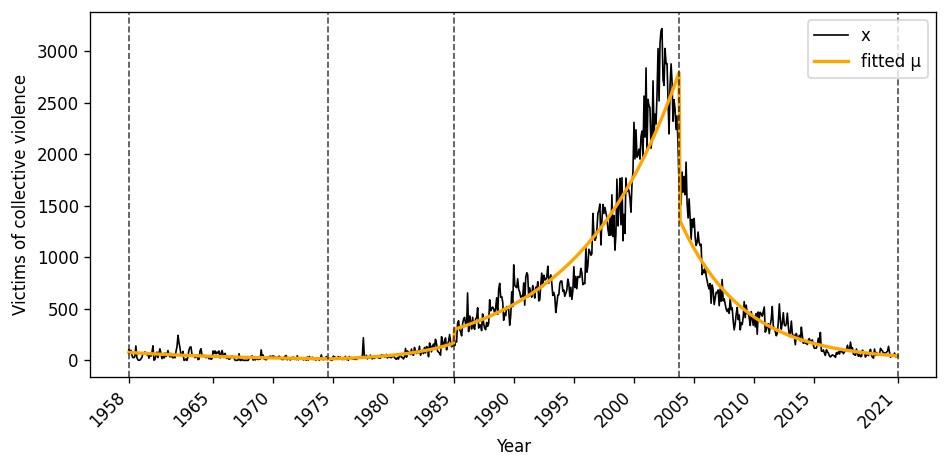

bkps with edges: [0, 190, 335, 550, 768]
alpha≈ 2.0573 | pen= 13.288
mean
332.0403645833333


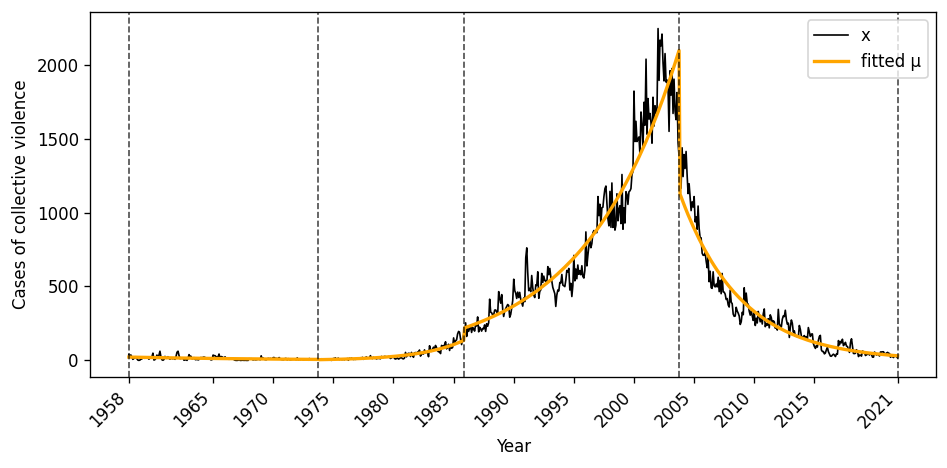

bkps with edges: [0, 115, 315, 550, 695, 768]
alpha≈ 1.4649 | pen= 13.288
mean
104.17447916666667


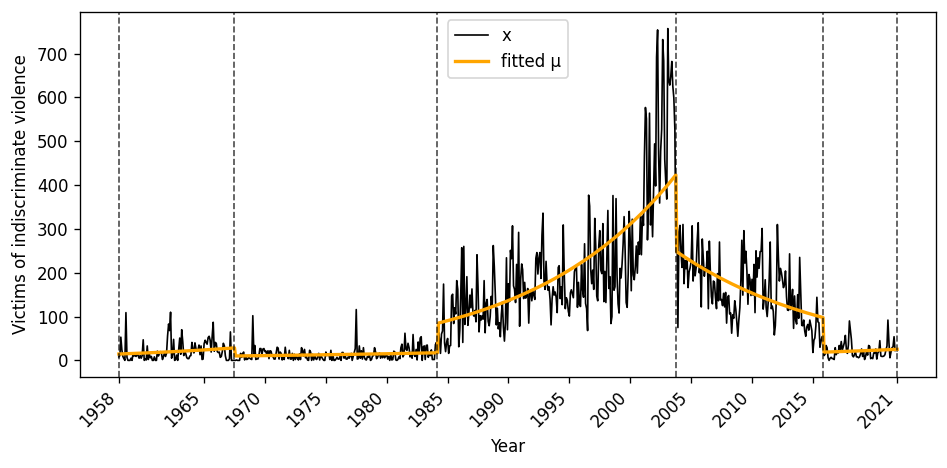

bkps with edges: [0, 85, 115, 325, 530, 768]
alpha≈ 1.4043 | pen= 13.288
mean
47.912760416666664


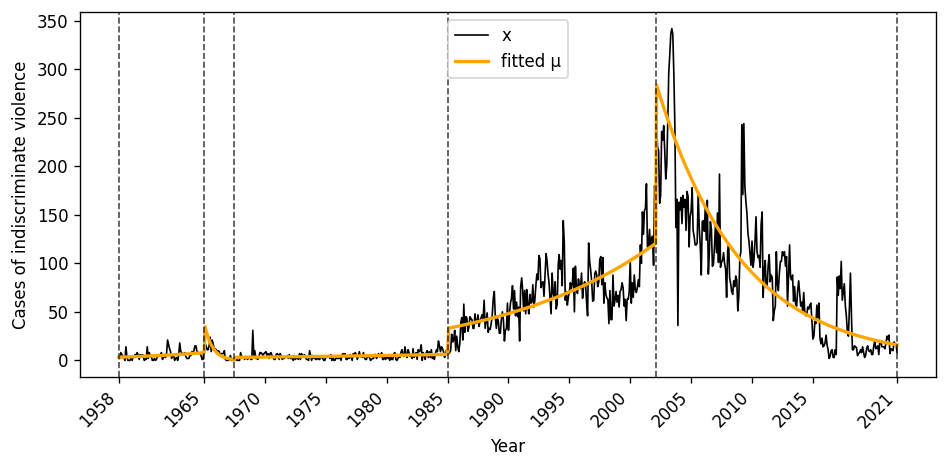

bkps with edges: [0, 190, 335, 560, 768]
alpha≈ 2.3187 | pen= 13.288
mean
357.90625


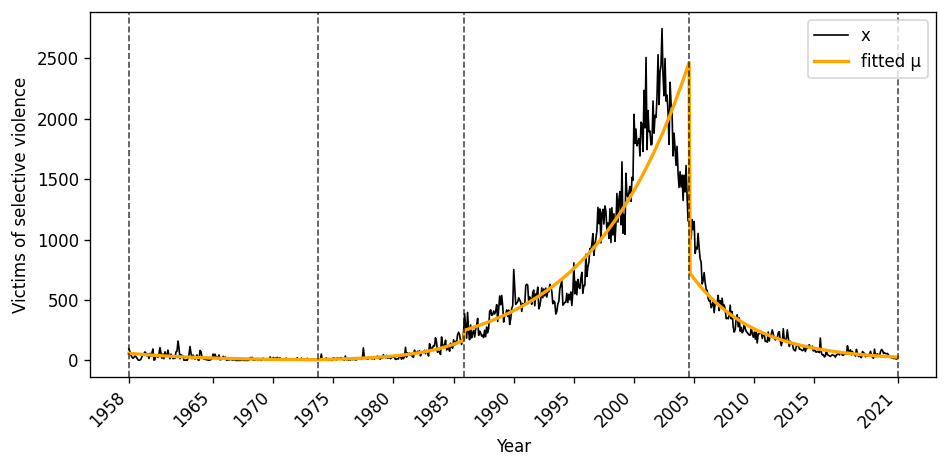

bkps with edges: [0, 190, 375, 550, 768]
alpha≈ 2.3139 | pen= 13.288
mean
284.1276041666667


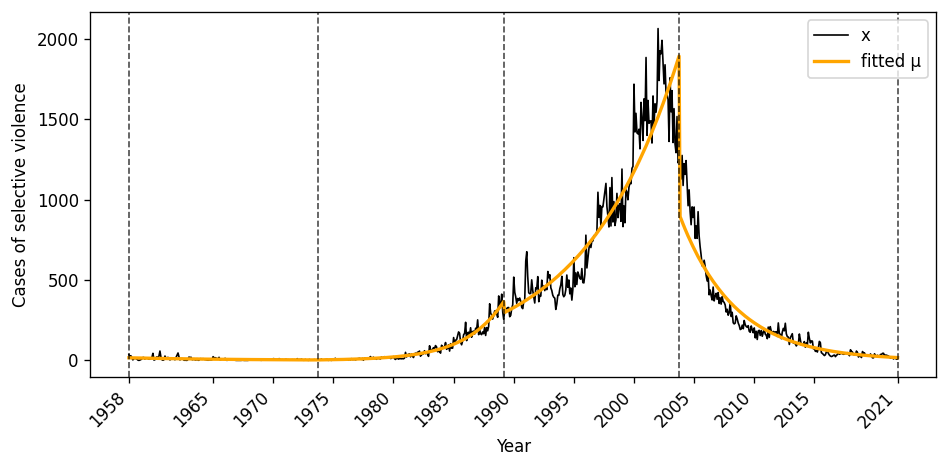

In [30]:
# @title
# Run PELT
datesOrig = dfDataOrig['period'].values.tolist()
dates = pd.to_datetime(dfDataOrig['period'], format="%Y/%m").values.tolist()
segmentsViolences = {}

fullSummaryBreakPoints = []
gmlModelResults = {}
for idIndicatorViolence in idIndicatorViolenceList:
  y = np.array(dfDataOrig[idIndicatorViolence].values.tolist())
  if modelSegmentation== "nb_const":
    bkps_with_edges, info = run_pelt_nb(y, model="nb_const", min_size=25, penalty="bic")
  elif modelSegmentation== "nb_glm_linear":
    bkps_with_edges, info = run_pelt_nb(y, model="nb_glm_linear", min_size=25, penalty="bic")
  elif modelSegmentation== "nb_glm_linear_pop":
    bkps_with_edges, info = run_pelt_nb(y, model="nb_glm_linear_pop", min_size=25, penalty="bic",
                                        df_monthly=df_monthly, pop_col="population", pop_log=True, pop_standardize=True)

  print("bkps with edges:", bkps_with_edges)   # includes 0 and T
  print("alpha≈", round(info["alpha"], 4), "| pen=", round(info["penalty"], 3))

  # 2) Store per-segment parameters (as list and DataFrame)
  seg_list, seg_df = segment_params_summary(y, bkps_with_edges, model=info["model"], alpha=info["alpha"],df_monthly=df_monthly)

  ends = [s["end"] for s in seg_list]
  changepointsList = ends[:-1]
  gmlModelResults[idIndicatorViolence] = [changepointsList,y]
  print('mean')
  print(np.mean(y))

  ticks = compute_time_ticks(dates[0], dates[-1], year_interval=5, include_edges=True)

  plot_series_with_bkps_and_fit(
      y, bkps_with_edges, model=info["model"], alpha=info["alpha"],
      title="",
      dates=dates, ticks=ticks, tick_fmt="%Y",label_y_axis = idIndicatorViolence,
      tick_font_size = 10,
      figsize=(8,4),
      df_monthly=df_monthly
  )
  fullSummaryBreakPoints.append([idIndicatorViolence,seg_list])

  segmentList = []
  for sl in seg_list:
    dateStart = (datesOrig[sl['start']])
    dateEnd = (datesOrig[sl['end']-1])
    date_fmt = pd.to_datetime(dateStart, format="%Y/%m")
    dateStart = date_fmt.strftime("%Y-%m-%d")
    date_fmt = pd.to_datetime(dateEnd, format="%Y/%m")
    dateEnd = date_fmt.strftime("%Y-%m-%d")
    segmentList.append((dateStart,dateEnd))
    segmentsViolences[idIndicatorViolence] = segmentList

segmentsViolences = dict(reversed(list(segmentsViolences.items())))